In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time

import healpy as hp
import pymaster as nmt
import pandas as pd

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils

## General

In [16]:
lmax = 4096
NSIDE = 2048
NPIX = hp.nside2npix(NSIDE)

## Load in Planck data

Data from https://pla.esac.esa.int/#cosmology, (cosmology tab then lensing tab)

Details: https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Lensing

In [2]:
fn_lensing = '../data/COM_Lensing_4096_R3.00/MV/dat_klm.fits'

Guidance here from: https://zonca.dev/2020/09/planck-spectra-healpy.html

In [3]:
alm_lensing = hp.read_alm(fn_lensing)

In [4]:
map_lensing = hp.alm2map(alm_lensing, nside=NSIDE, lmax=lmax)

In [5]:
fn_mask = '../data/COM_Lensing_4096_R3.00/mask.fits.gz'
mask = hp.read_map(fn_mask, dtype=bool)

In [6]:
aposize_deg = 0.5 #30' (arcmin)
mask_apod = nmt.mask_apodization(mask, aposize_deg, apotype="C2")

In [7]:
map_lensing_masked = hp.ma(map_lensing)
map_lensing_masked.mask = np.logical_not(mask_apod)

0.0 180.0 -180.0 180.0


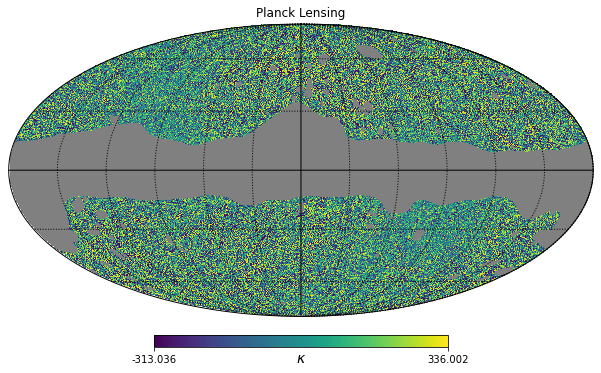

In [8]:
hp.mollview(
    map_lensing_masked,
    title=rf"Planck Lensing",
    unit=r"$\kappa$",
    norm="hist",
    cmap='viridis',
    #coord=['C', 'G']
    #min=-1.5,
    #max=1.5,
)
hp.graticule()

In [9]:
# can't figure out how to set lmin! but this fixes the scaling
# should i mask and then smooth or vice versa??
map_lensing_smooth = hp.smoothing(map_lensing_masked, lmax=1000)

0.0 180.0 -180.0 180.0


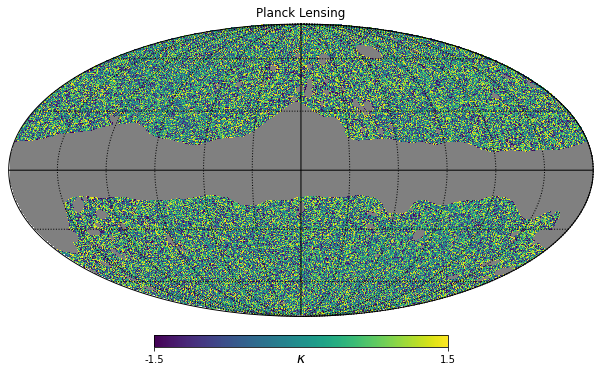

In [10]:
hp.mollview(
    map_lensing_smooth,
    title=rf"Planck Lensing",
    unit=r"$\kappa$",
    norm="hist",
    cmap='viridis',
    #coord=['C', 'G']
    min=-1.5,
    max=1.5,
)
hp.graticule()

## Gaia quasars

In [3]:
tab_gaia = Table.read('../data/gaia_wise_panstarrs_tmass.fits.gz', format='fits')
print('Total number of Gaia quasars:', len(tab_gaia))

Total number of Gaia quasars: 6649162


In [4]:
fn_spz = '../data/redshifts_spz_kNN.fits'
tab_spz = Table.read(fn_spz, format='fits')

In [5]:
assert np.allclose(tab_gaia['source_id'], tab_spz['source_id']), "Source IDs don't line up! They should by construction"

In [6]:
tab_gaia.add_column(tab_spz['redshift_spz'], name='redshift_spz')
tab_gaia.add_column(tab_spz['redshift_sdss'], name='redshift_sdss')

In [7]:
idx_withspz = np.isfinite(tab_gaia['redshift_spz'])
np.sum(idx_withspz)

648842

The sample that has speczs is our cleaner sample of G<20 and QSO color cuts:

In [33]:
NSIDE

2048

In [72]:
ra_gaia = tab_gaia['ra'][idx_withspz]
dec_gaia = tab_gaia['dec'][idx_withspz]
map_nqso_gaia, pixel_indices = utils.get_map(64, ra_gaia, dec_gaia, null_val=0)

In [73]:
len(map_nqso_gaia), np.max(map_nqso_gaia[np.isfinite(map_nqso_gaia)])

(49152, 44)

In [74]:
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)
area_all = area_per_pixel*NPIX

In [75]:
map_ndens_gaia = map_nqso_gaia/area_all

0.0 180.0 -180.0 180.0


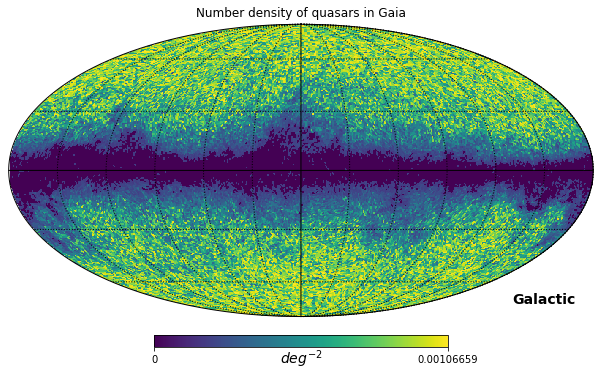

In [76]:
hp.mollview(
    map_ndens_gaia,
    title=rf"Number density of quasars in Gaia",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=1,
)
hp.graticule()

In [77]:
fac_rand = 10
fn_rand = f'../data/random_dust_{fac_rand}.fits'
tab_rand = utils.load_table(fn_rand)

In [78]:
len(tab_rand)

6475263

In [84]:
ra_rand = tab_rand['ra']
dec_rand = tab_rand['dec']
map_nqso_rand, pixel_indices_rand = utils.get_map(64, ra_rand, dec_rand, null_val=0)

In [85]:
map_ndens_rand = map_nqso_rand/area_all

0.0 180.0 -180.0 180.0


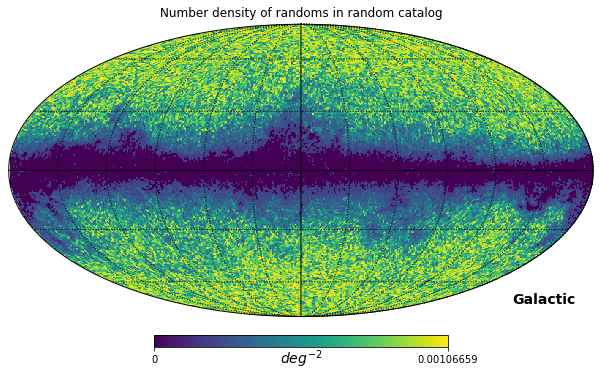

In [86]:
hp.mollview(
    map_ndens_gaia,
    title=rf"Number density of randoms in random catalog",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=1,
)
hp.graticule()

"The weighted random counts in each Healpix pixel then form the “random map”. The overdensity field is defined as the “LRG map” divided by the “random map”, normalized to mean density and mean subtracted." (White 2022)

TODO: figure out what to do about these zeros!

In [87]:
map_overdensity = map_ndens_gaia / map_ndens_rand
map_overdensity /= np.mean(map_overdensity) #?? is this what normalized to mean density means?
map_overdensity -= np.mean(map_overdensity)

/var/folders/7t/rc3c2v49239cr68whtd51wtr0000gn/T/ipykernel_20527/3771452085.py:1: RuntimeWarning: divide by zero encountered in divide
  map_overdensity = map_ndens_gaia / map_ndens_rand
/var/folders/7t/rc3c2v49239cr68whtd51wtr0000gn/T/ipykernel_20527/3771452085.py:1: RuntimeWarning: invalid value encountered in divide
  map_overdensity = map_ndens_gaia / map_ndens_rand


0.0 180.0 -180.0 180.0


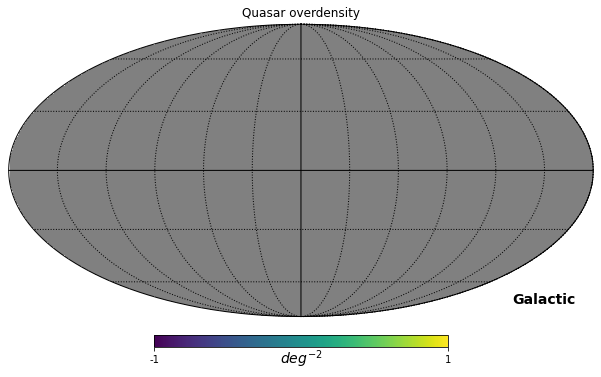

In [88]:
hp.mollview(
    map_overdensity,
    title=rf"Quasar overdensity",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=1,
)
hp.graticule()

## Compute pseudo-Cls

Following https://arxiv.org/pdf/2111.09898.pdf and https://namaster.readthedocs.io/en/latest/sample_simple.html

In [16]:
# Read healpix maps and initialize a spin-0 and spin-2 field
field = nmt.NmtField(mask_apod, [map_lensing_smooth])

"We choose a conservative binning scheme with linearly spaced bins of
size ∆l = 50 starting from l_min = 25."

In [43]:
# Initialize binning scheme with 4 ells per bandpower
#b = nmt.NmtBin.from_nside_linear(nside, 4)
ell_min = 25
ell_max = 6000
ell_bin_width = 50
ell_edges = np.arange(ell_min, ell_max+ell_bin_width, ell_bin_width)
ell_ini = ell_edges[:-1]
ell_end = ell_edges[1:]
b = nmt.NmtBin.from_edges(ell_ini, ell_end)

In [26]:
# Compute MASTER estimator
cl_00 = nmt.compute_full_master(field, field, b)

In [39]:
# Initialize binning scheme with 4 ells per bandpower
#b = nmt.NmtBin.from_nside_linear(nside, 4)
ell_min = 25
ell_max = 600
ell_bin_width = 50
ell_edges = np.arange(ell_min, ell_max+ell_bin_width, ell_bin_width)
ell_ini = ell_edges[:-1]
ell_end = ell_edges[1:]
b_cut = nmt.NmtBin.from_edges(ell_ini, ell_end)

In [40]:
# Compute MASTER estimator
cl_00_cut = nmt.compute_full_master(field, field, b_cut)

In [29]:
mult_fac = 1e6

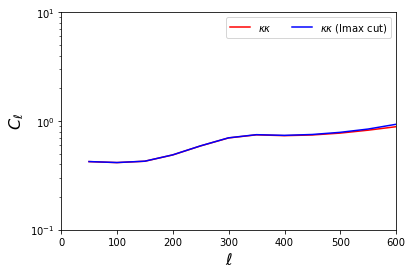

In [46]:
ell_arr = b.get_effective_ells()
ell_arr_cut = b_cut.get_effective_ells()
plt.plot(ell_arr, mult_fac*cl_00[0], 'r-', label=r'$\kappa \kappa$')
plt.plot(ell_arr_cut, mult_fac*cl_00_cut[0], 'b-', label=r'$\kappa \kappa$ (lmax cut)')
plt.yscale('log')
plt.xlim(0, 600)
plt.ylim(1e-1, 1e1)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$10^6 C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

In [58]:
# Initialize binning scheme with 4 ells per bandpower
#b = nmt.NmtBin.from_nside_linear(nside, 4)
ell_min_log = 1
ell_max_log = 3
n_ell_bins_log = 20
ell_edges_log = np.array(np.round(np.logspace(ell_min_log, ell_max_log, n_ell_bins_log)), dtype=int)
ell_ini_log = ell_edges_log[:-1]
ell_end_log = ell_edges_log[1:]
b_log = nmt.NmtBin.from_edges(ell_ini_log, ell_end_log)

In [59]:
ell_edges_log

array([  10,   13,   16,   21,   26,   34,   43,   55,   70,   89,  113,
        144,  183,  234,  298,  379,  483,  616,  785, 1000])

In [60]:
# Compute MASTER estimator
cl_00_log = nmt.compute_full_master(field, field, b_log)

In [29]:
mult_fac = 1e6

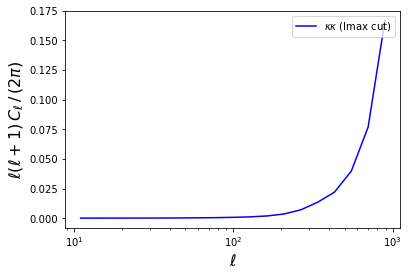

In [65]:
ell_arr_log = b_log.get_effective_ells()
prefac = ell_arr_log*(ell_arr_log+1)/(2*np.pi)
plt.plot(ell_arr_log, prefac*cl_00_log[0], 'b-', label=r'$\kappa \kappa$ (lmax cut)')
plt.xscale('log')
#plt.xlim(0, 600)
#plt.ylim(1e-1, 1e1)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel(r'$\ell(\ell+1) \, C_\ell \, / \, (2\pi)$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()